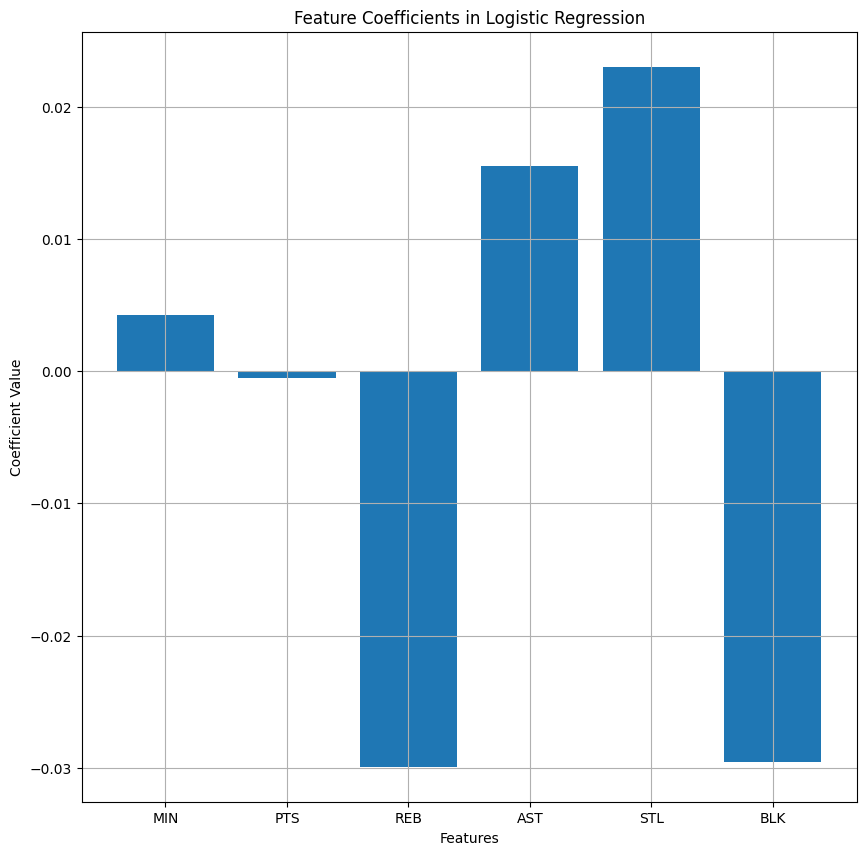

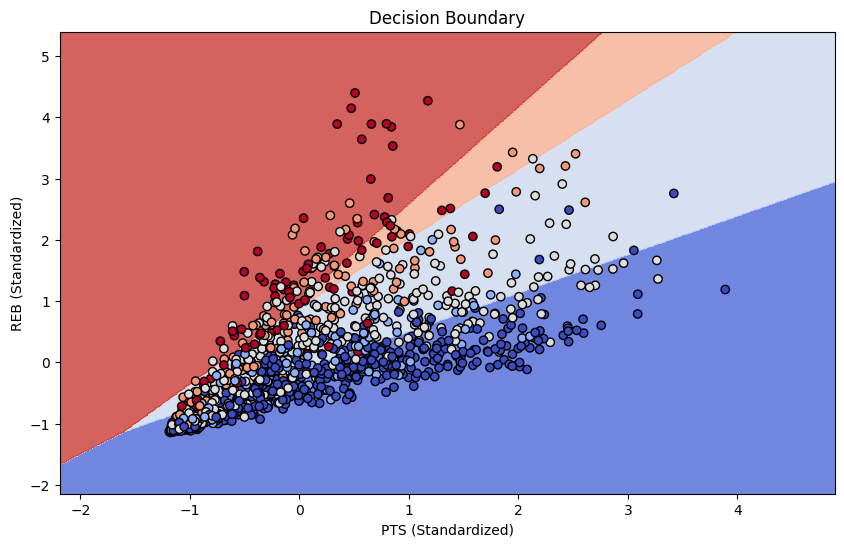

The accuracy of the model is: 0.6366


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split # to split training and testing
from sklearn.linear_model import LogisticRegression # To calculate the w value and bias
from sklearn.metrics import accuracy_score # Later to calculate prediction and accuracy
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA




season_stats = pd.read_csv("players_stats_by_season_with_position.csv")

# Set which one is input and which one is output
X = season_stats[[ 'MIN', "PTS", "REB", "AST", "STL", "BLK"]]
y = season_stats["position_number"].astype(str) 

# Set which one is the training and which one is the testing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # All the input scales are different
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Now ask them to make model. Used saga because there is a lot of classes for input. Also used regularization
#lbfgs 
model = LogisticRegression(max_iter = 5000, solver= 'saga', penalty = 'elasticnet', l1_ratio=0.5, C=1.0)
model.fit(X_train, y_train)

# Prediction and Accuracy
y_prec = model.predict(X_test)
accuracy = accuracy_score(y_test, y_prec)

# Making a model between coefficient value and features
coefficients = model.coef_[0]  # To make the graph 1d
feature_names = X.columns     

plt.figure(figsize=(10,10))
plt.bar(feature_names, coefficients)
plt.title('Feature Coefficients in Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.show()

# 
# 1. 데이터 준비
X = season_stats[['PTS', 'REB']]  # 예시로 2개만
y = season_stats["position_number"]  # 여기 고쳤음!!

# 2. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. 모델 학습
model = LogisticRegression(max_iter=5000, solver='saga', penalty='elasticnet', l1_ratio=0.5)
model.fit(X_train, y_train)

# 5. 메쉬그리드
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.astype(float)  # 혹시 모를 오류 대비
Z = Z.reshape(xx.shape)

# 6. Plot
plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel('PTS (Standardized)')
plt.ylabel('REB (Standardized)')
plt.title('Decision Boundary')
plt.show()





print(f"The accuracy of the model is: {accuracy:.4f}")
